In [1]:
import os
import pyedflib
import glob
import mne
import numpy as np
import mne_features
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  recall_score, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
from scipy.stats import mode
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
file_path = glob.glob("C:/Users/ASUS/OneDrive/Documents/Semester 7/Tugas Akhir/5 menit/After Flash 5 menit/*.edf")
print(len(file_path))

21


In [3]:
#Split data sesuai kondisi
Sedang_path = [i for i in file_path if os.path.basename(i).startswith('S')]
Ringan_path = [i for i in file_path if os.path.basename(i).startswith('R')]
Normal_path = [i for i in file_path if os.path.basename(i).startswith('N')]
print(len(Sedang_path),len(Ringan_path),len(Normal_path))

4 6 11


# Visualisasi

## Timeseries plot

Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_7.edf...
EDF file detected


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\1668872494.py:2: RuntimeWarning: Omitted 54 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\SAF_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\1668872494.py:2: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\1668872494.py:2: RuntimeWarning: Omitted 6 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


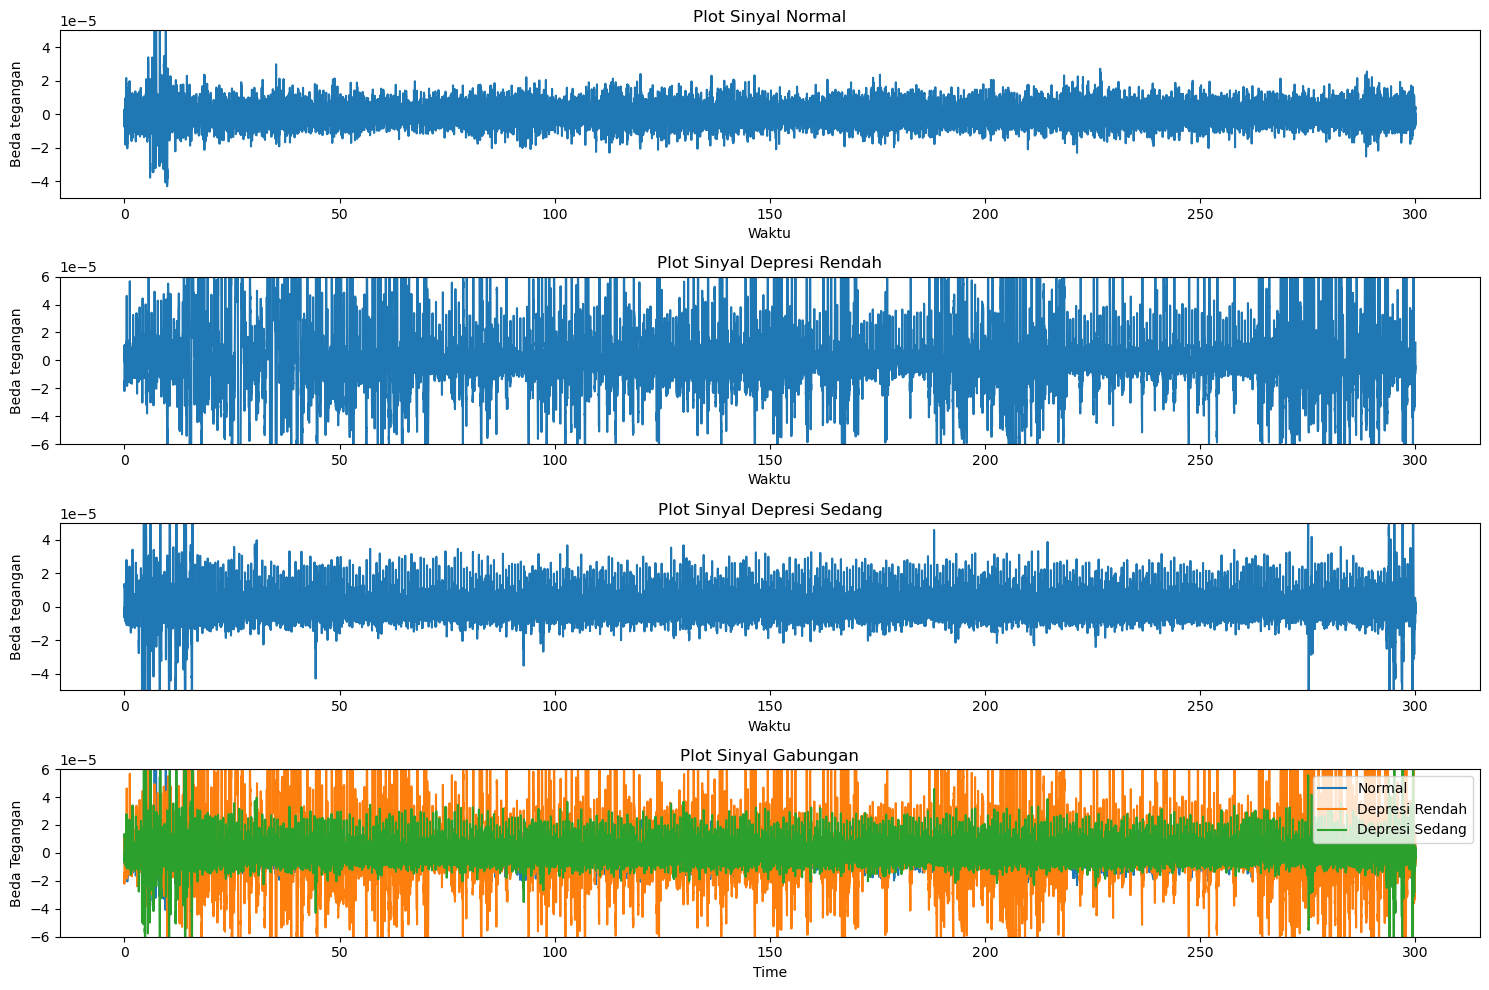

In [84]:
def read_raw_eeg(path):
    data = mne.io.read_raw_edf(path, preload=True)
    data = data.crop(tmin=0, tmax=300)  # Ambil 5 menit pertama
    data.set_eeg_reference()

    # Pilih hanya channel EEG FP1-R
    channel_name = ['EEG FP1-R']
    data = data.pick_channels(channel_name)

    # Ambil data dan sampling rate
    signal, times = data.get_data(return_times=True)
    return signal[0], data.info['sfreq']  # ambil array 1D & sampling rate

# ...existing code...

# Ubah label dan variabel sesuai permintaan
normal_signal, fs = read_raw_eeg(Normal_path[8])
depresi_ringan_signal, _ = read_raw_eeg(Ringan_path[0])
depresi_sedang_signal, _ = read_raw_eeg(Sedang_path[2])

# Buat sumbu waktu
t_normal = np.arange(len(normal_signal)) / fs
t_depresi_ringan = np.arange(len(depresi_ringan_signal)) / fs
t_depresi_sedang = np.arange(len(depresi_sedang_signal)) / fs

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(t_normal, normal_signal)
plt.title('Plot Sinyal Normal')
plt.ylabel('Beda tegangan')
plt.xlabel('Waktu')
plt.ylim(-5e-5, 5e-5)  # Set y-axis limits

plt.subplot(4, 1, 2)
plt.plot(t_depresi_ringan, depresi_ringan_signal)
plt.title('Plot Sinyal Depresi Rendah')
plt.ylabel('Beda tegangan')
plt.xlabel('Waktu')
plt.ylim(-6e-5, 6e-5)  # Set y-axis limits

plt.subplot(4, 1, 3)
plt.plot(t_depresi_sedang, depresi_sedang_signal)
plt.title('Plot Sinyal Depresi Sedang')
plt.ylabel('Beda tegangan')
plt.xlabel('Waktu')
plt.ylim(-5e-5, 5e-5)  # Set y-axis limits

plt.subplot(4, 1, 4)
plt.plot(t_normal, normal_signal, label='Normal')
plt.plot(t_depresi_ringan, depresi_ringan_signal, label='Depresi Rendah')
plt.plot(t_depresi_sedang, depresi_sedang_signal, label='Depresi Sedang')
plt.title('Plot Sinyal Gabungan')
plt.xlabel('Time')
plt.ylabel('Beda Tegangan')
plt.ylim(-6e-5, 6e-5)  # Set y-axis limits
plt.legend()

plt.tight_layout()
plt.show()

## Boxplot

Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\SAF_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\SAF_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\SAF_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\SAF_4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 6 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 5 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Reading 0 ... 150499  =      0.000 ...   300.998 secs...
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 5 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 48 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 90 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 17 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 15 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 82 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 160 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 54 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 35 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:5: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\2026052798.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Kondisi', y='Data', data=df,


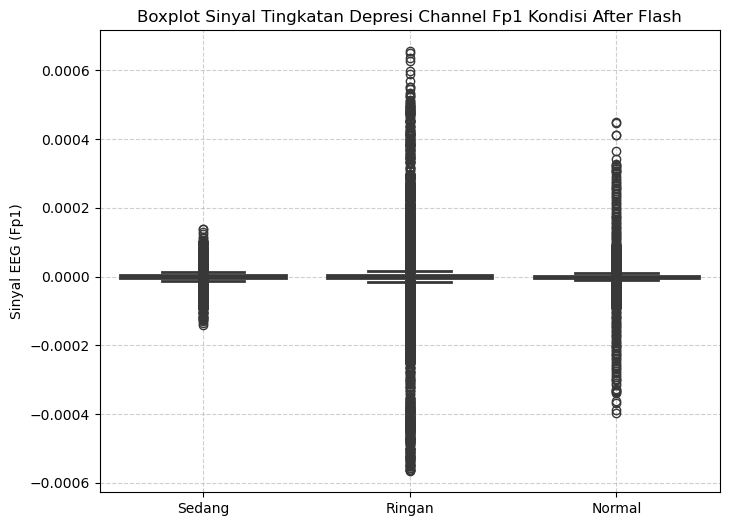

In [78]:
# Fungsi untuk mengekstrak sinyal dari channel Fp1
def extract_fp1_signal(file_list, label):
    all_signals = []
    for file in file_list:
        raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG
        if 'EEG FP1-R' in raw.ch_names:  # Pastikan channel Fp1 tersedia
            fp1_data = raw.get_data(picks='EEG FP1-R').flatten()  # Ambil data dan flatten
            all_signals.extend(fp1_data)  # Simpan semua data
    return pd.DataFrame({'Data': all_signals, 'Kondisi': label})

# Ambil data untuk masing-masing kondisi
df_sedang = extract_fp1_signal(Sedang_path, 'Sedang')
df_ringan = extract_fp1_signal(Ringan_path, 'Ringan')
df_normal = extract_fp1_signal(Normal_path, 'Normal')

# Gabungkan semua data
df = pd.concat([df_sedang, df_ringan, df_normal], ignore_index=True)

plt.figure(figsize=(8, 6))

# Plot boxplot
sns.boxplot(x='Kondisi', y='Data', data=df, 
            palette=['#F8766D', '#00BA38', '#619CFF'], 
            linewidth=2)

plt.xlabel("")
plt.ylabel("Sinyal EEG (Fp1)")
plt.title("Boxplot Sinyal Tingkatan Depresi Channel Fp1 Kondisi After Flash")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# Fungsi untuk mengekstrak sinyal dari channel Fp2
def extract_fp1_signal(file_list, label):
    all_signals = []
    for file in file_list:
        raw = mne.io.read_raw_edf(file, preload=True)  # Load file EEG
        if 'EEG FP2-R' in raw.ch_names:  # Pastikan channel Fp2 tersedia
            fp1_data = raw.get_data(picks='EEG FP2-R').flatten()  # Ambil data dan flatten
            all_signals.extend(fp1_data)  # Simpan semua data
    return pd.DataFrame({'Data': all_signals, 'Kondisi': label})

# Ambil data untuk masing-masing kondisi
df_sedang = extract_fp1_signal(Sedang_path, 'Sedang')
df_ringan = extract_fp1_signal(Ringan_path, 'Ringan')
df_normal = extract_fp1_signal(Normal_path, 'Normal')

# Gabungkan semua data
df = pd.concat([df_sedang, df_ringan, df_normal], ignore_index=True)

plt.figure(figsize=(8, 6))

# Plot boxplot
sns.boxplot(x='Kondisi', y='Data', data=df, 
            palette=['#F8766D', '#00BA38', '#619CFF'], 
            linewidth=2)

plt.xlabel("")
plt.ylabel("Sinyal EEG (Fp2)")
plt.title("Boxplot Sinyal Tingkatan Depresi Channel Fp2 Kondisi After Flash")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Filtasi dan segmentasi

In [4]:
# Definisikan Rentang frekuensi
lowc = [0.1, 4.1, 8.1, 13.1, 30.1] #batas bawah
highc = [4, 8, 13, 30, 50] #batas atas
    
def read_data(path):
    data = mne.io.read_raw_edf(path, preload=True)
    data_use = data.copy().crop(tmin=0, tmax=300)
    data_use.set_eeg_reference()

    # Pilih hanya channel yang diinginkan
    channel_name = ['EEG FP1-R', 'EEG FP2-R']
    data_use = data_use.pick_channels(channel_name)

    arrays = []  # Untuk menyimpan data dari setiap rentang frekuensi

    for i in range(len(lowc)):
        # Filtering berdasarkan rentang frekuensi dengan fir_window='hamming'
        filtered_data = data_use.copy().filter(
            l_freq=lowc[i], 
            h_freq=highc[i], 
            fir_window='hamming',  # Tambahkan parameter ini
            verbose=False
        )

        # Buat epochs tanpa plotting
        epochs = mne.make_fixed_length_epochs(filtered_data, duration=10, overlap=5, verbose=False)

        # Konversi menjadi array
        array_band = epochs.get_data(picks=channel_name)
        arrays.append(array_band)

    # Gabungkan semua array dari setiap rentang frekuensi
    combined_array = np.hstack(arrays)
    return np.array(combined_array)

# Mengambil data untuk setiap jenis path tanpa plotting
Sedang_array = [read_data(i) for i in Sedang_path]
Ringan_array = [read_data(i) for i in Ringan_path]
Normal_array = [read_data(i) for i in Normal_path]


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\SAF_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\SAF_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
A

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\SAF_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 6 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\SAF_4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. Ne

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 5 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. Ne

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. Ne

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\RAF_7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 5 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. Ne

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 48 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 90 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 17 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 15 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
A

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 82 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 160 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. Ne

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 54 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 35 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\After Flash 5 menit\NAF_9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6008\1771977834.py:6: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped


In [20]:
print(Sedang_array[0].shape)  # Cek dimensi output
print(Ringan_array[0].shape)  # Cek apakah bentuknya konsisten
print(Normal_array[0].shape)
print("Jumlah subjek di Sedang_array:", len(Sedang_array))
print("Jumlah subjek di Ringan_array:", len(Ringan_array))
print("Jumlah subjek di Normal_array:", len(Normal_array))

(59, 10, 5000)
(59, 10, 5000)
(59, 10, 5000)
Jumlah subjek di Sedang_array: 4
Jumlah subjek di Ringan_array: 6
Jumlah subjek di Normal_array: 11


In [21]:
# Pembuatan list untuk label: Normal = 1, Ringan = 2, Sedang = 3
Normal_label = [len(i) * [1] for i in Normal_array]
Ringan_label = [len(i) * [2] for i in Ringan_array]
Sedang_label = [len(i) * [3] for i in Sedang_array]


len(Normal_label), len(Ringan_label), len(Sedang_label)


(11, 6, 4)

In [22]:
Data_list =  Normal_array + Ringan_array + Sedang_array
Label_list = Normal_label + Ringan_label + Sedang_label
group_list = [[i] * len(j) for i, j in enumerate(Data_list)]

Data_array = np.vstack(Data_list)
label_array = np.hstack(Label_list)
Group_array = np.hstack(group_list)

print(Data_array.shape, label_array.shape, Group_array.shape)


(1239, 10, 5000) (1239,) (1239,)


In [23]:
# Mengubah menjadi dua dimensi dengan menggunakan reshape()
Data_array_2d = Data_array.reshape(-1, Data_array.shape[-1])
print(Data_array_2d.shape)

# Mendapatkan labe  l sesuai dengan Data_array_2d
label_array_2d = np.repeat(label_array, Data_array_2d.shape[0] // len(label_array))

(12390, 5000)


In [24]:
baris = Data_array.shape[0]

# Ekstraksi Fitur

In [25]:
##Extraksi Fitur
from scipy import stats

def minimum(x):
  return np.min(x, axis=-1)
def maksimum(x):
  return np.max(x, axis=-1)
def skewness(x):
  return stats.skew(x, axis = -1)
def kurtosis(x):
  return stats.kurtosis(x, axis = -1)
def entropy(x):
  return mne_features.univariate.compute_spect_entropy(sfreq=500,data=x)
def concatenate_features(x):
  return np.concatenate((minimum(x), maksimum(x), skewness(x), kurtosis(x), entropy(x)), axis=-1)

fitur= []
for i in Data_array:
 fitur.append(concatenate_features (i))

fitur_array = np.array(fitur)

In [26]:
#Penggabungan fitur array dengan label kelas
label_array1 = label_array.reshape(baris, 1)
combined_array = np.concatenate((fitur_array, label_array1), axis=1)

In [27]:
# Cetak bentuk hasil gabungan
print(combined_array.shape)

(1239, 51)


In [28]:
df_fitur = pd.DataFrame(combined_array)

In [ ]:
# Definisikan daftar nama fitur
fitur = ['minimum', 'maksimum', 'skewness', 'kurtosis', 'entropy']

# Definisikan daftar nama sub-band
sub_band = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Definisikan daftar nama channel EEG
channel = ['FP1','FP2']

# Inisialisasi list nama kolom
nama_kolom = []

# Looping untuk menggabungkan nama kolom
for f in fitur:
  for sb in sub_band:
    for ch in channel:
      nama_kolom.append(f + '_' + sb + '_' + ch)

nama_kolom.append('kelas')

# Inisialisasi list fitur
fitur = []

# Loop melalui Data_array dan tambahkan fitur hasil concatenate ke dalam list fitur
for i in Data_array:
    fitur.append(concatenate_features(i))

# Konversi list fitur menjadi numpy array
fitur_array = np.array(fitur)

#Gabungkan fitur array sama group dan label
label_array1 = label_array.reshape(baris, 1)
combined_array = np.concatenate((fitur_array, label_array1), axis=1)

# Buat DataFrame dari fitur_array dengan nama kolom
df_fitur = pd.DataFrame(combined_array, columns=nama_kolom)

# Simpan DataFrame ke dalam file CSV
#df_fitur.to_csv('fitur_afterflash.csv', index=True)

# Pembagian Training testing

In [32]:
X = df_fitur.drop(columns=['kelas'])  # Fitur (tanpa label)
y = df_fitur['kelas']  # Target/label

In [33]:
#X = X_scaled.reset_index(drop=True)
y = y.reset_index(drop=True)

X_train_list = []
y_train_list = []

np.random.seed(42)  # Agar hasil konsisten

# 2. Lakukan bootstrap per kelas
for kelas in y.unique():
    idx_kelas = y[y == kelas].index  # Ambil indeks dari label kelas ini
    sampled_idx = np.random.choice(idx_kelas, size=len(idx_kelas), replace=True)

    X_train_list.append(X.loc[sampled_idx])
    y_train_list.append(y.loc[sampled_idx])

# 3. Gabungkan hasil sampling
X_train = pd.concat(X_train_list).reset_index(drop=True)
y_train = pd.concat(y_train_list).reset_index(drop=True)

# 4. Tentukan data test
# Data test adalah yang tidak terpilih sama sekali
selected_idx = set(sampled_idx for kelas in y.unique()
                   for sampled_idx in np.random.choice(
                       y[y == kelas].index, size=len(y[y == kelas]), replace=True))

all_idx = set(range(len(X)))
test_idx = list(all_idx - selected_idx)

X_test = X.loc[test_idx].reset_index(drop=True)
y_test = y.loc[test_idx].reset_index(drop=True)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1239, 50)
y_train shape: (1239,)
X_test shape: (491, 50)
y_test shape: (491,)


# Klasifikasi

## Tunning

In [39]:
# Definisikan parameter yang akan dicoba dalam GridSearch
param_grid = {
    'C': [1, 10, 100],  # tambahkan regularisasi tinggi (C kecil)
    'kernel': ['linear', 'rbf'],  # fokus ke linear dan rbf
    'gamma': ['scale', 'auto'],  # untuk rbf, tambahkan nilai gamma kecil (lebih halus)
    #'class_weight': ['balanced'] # tetap seimbangkan kelas
}

# Inisialisasi model SVM
svm = SVC()

# Grid Search dengan Cross Validation (cv=5)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=2, verbose=1)
grid_search.fit(X_train, y_train)


# **Ambil parameter terbaik**
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# **Step 2: Gunakan best parameters untuk SVM**
best_svm = SVC(**best_params, decision_function_shape='ovo', probability=True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


## SVM Biasa

SVM Training Accuracy: 0.9984
SVM Testing Accuracy: 0.9104
F1 Score (Macro): 0.9002

Classification Report:
              precision    recall  f1-score   support

         1.0     0.9438    0.9252    0.9344       254
         2.0     0.8993    0.8929    0.8961       140
         3.0     0.8447    0.8969    0.8700        97

    accuracy                         0.9104       491
   macro avg     0.8959    0.9050    0.9002       491
weighted avg     0.9115    0.9104    0.9107       491

Sensitivity (Macro Recall): 0.9050


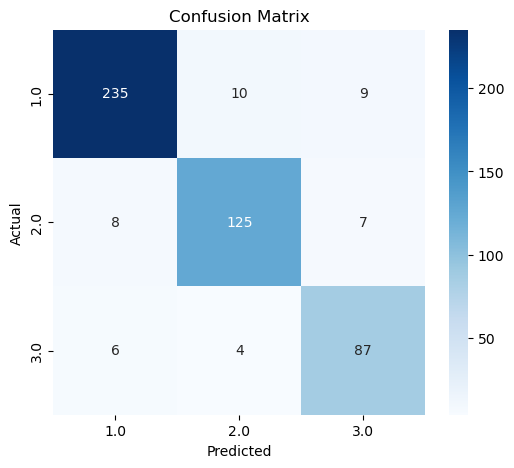

Specificity (Macro): 0.9535


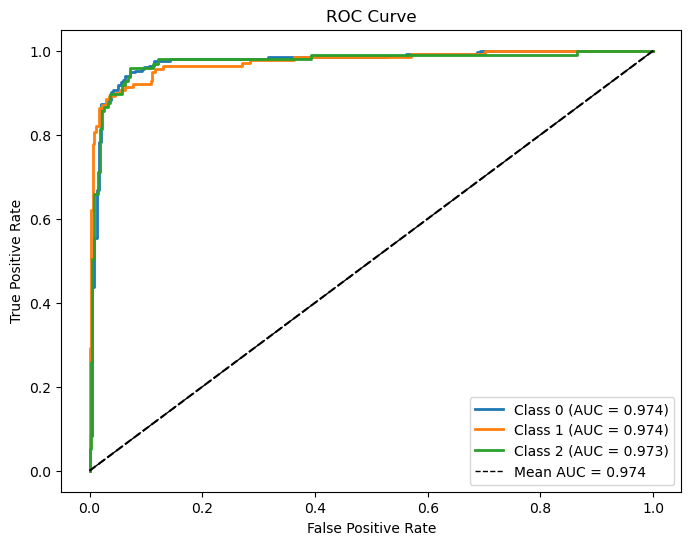

In [40]:
# **Step 1: Training model**
best_svm.fit(X_train, y_train)

# **Step 2: Prediksi di training dan testing**
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

# **Step 3: Hitung Akurasi**
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"SVM Training Accuracy: {train_accuracy:.4f}")
print(f"SVM Testing Accuracy: {test_accuracy:.4f}")

# Hitung f1_macro
f1_macro = f1_score(y_test, y_test_pred, average='macro')
print(f"F1 Score (Macro): {f1_macro:.4f}")

# Tampilkan classification report lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))


# **Step 5: Sensitivity & Specificity**
# Sensitivity (macro recall)
sensitivity = recall_score(y_test, y_test_pred, average='macro')
print(f"Sensitivity (Macro Recall): {sensitivity:.4f}")

# **Step 4: Confusion Matrix**
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Specificity untuk multiclass
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)
mean_specificity = np.mean(specificities)
print(f"Specificity (Macro): {mean_specificity:.4f}")

# **Step 6: ROC Curve dan AUC**
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
y_test_prob = best_svm.predict_proba(X_test)  # Probabilitas prediksi
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8,6))
auc_values = []

# ROC untuk tiap kelas
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    auc_values.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

# Mean AUC
mean_auc = np.mean(auc_values)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label=f'Mean AUC = {mean_auc:.3f}')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Bagging SVM 

In [79]:
# **Step 3: Masukkan SVM ke dalam BaggingClassifier**
bagging_classifier = BaggingClassifier(
    estimator=best_svm,
    n_estimators=100,
    bootstrap=True,
    max_samples=0.8,
    max_features=0.8,
    random_state=42
)

# **Step 4: Train BaggingClassifier**
bagging_classifier.fit(X_train, y_train)


# **Step 5: Prediksi dan Evaluasi**
y_train_pred = bagging_classifier.predict(X_train)
y_test_pred = bagging_classifier.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Bagging SVM Training Accuracy: {train_accuracy:.4f}')
print(f'Bagging SVM Testing Accuracy: {test_accuracy:.4f}')

# Hitung f1_macro
f1_macro = f1_score(y_test, y_test_pred, average='macro')
print(f"F1 Score (Macro): {f1_macro:.4f}")

# Tampilkan classification report lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# **Step 6: Confusion Matrix**
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Step 7: Sensitivitas dan Spesifisitas**
# Sensitivitas (Recall Macro)
sensitivity = recall_score(y_test, y_test_pred, average='macro')
print(f"Sensitivity (Macro Recall): {sensitivity:.4f}")

# Spesifisitas untuk multiclass
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)
mean_specificity = np.mean(specificities)
print(f"Specificity (Macro): {mean_specificity:.4f}")

# **Step 6: ROC Curve dan AUC**
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
y_test_prob = best_svm.predict_proba(X_test)  # Probabilitas prediksi
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8,6))
auc_values = []

# ROC untuk tiap kelas
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    auc_values.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

# Mean AUC
mean_auc = np.mean(auc_values)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label=f'Mean AUC = {mean_auc:.3f}')

# Format plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print Mean AUC di konsol
print(f"Mean AUC: {mean_auc:.3f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


KeyboardInterrupt: 

# Predict

In [42]:
file_path = glob.glob("C:/Users/ASUS/OneDrive/Documents/Semester 7/Tugas Akhir/5 menit/Data predict after flash/*.edf")
print(len(file_path))

3


In [43]:
#Split data sesuai kondisi
PS_path = [i for i in file_path if os.path.basename(i).startswith('S')]
PR_path = [i for i in file_path if os.path.basename(i).startswith('R')]
PN_path = [i for i in file_path if os.path.basename(i).startswith('N')]
print(len(PS_path),len(PR_path),len(PN_path))

1 1 1


In [44]:
# Definisi rentang frekuensi
lowc = [0.1, 4.1, 8.1, 13.1, 30.1]  # Batas bawah
highc = [4, 8, 13, 30, 50]  # Batas atas

In [45]:
def read_data(path):
    data = mne.io.read_raw_edf(path, preload=True)
    data_use = data.copy().crop(tmin=0, tmax=300)
    data_use.set_eeg_reference()

    # Pilih hanya channel yang diinginkan
    channel_name = ['EEG FP1-R', 'EEG FP2-R']
    data_use = data_use.pick_channels(channel_name)

    arrays = []  # Untuk menyimpan data dari setiap rentang frekuensi

    for i in range(len(lowc)):
        # Filtering berdasarkan rentang frekuensi dengan fir_window='hamming'
        filtered_data = data_use.copy().filter(
            l_freq=lowc[i], 
            h_freq=highc[i], 
            fir_window='hamming',  # Tambahkan parameter ini
            verbose=False
        )

        # Buat epochs tanpa plotting
        epochs = mne.make_fixed_length_epochs(filtered_data, duration=10, overlap=5, verbose=False)

        # Konversi menjadi array
        array_band = epochs.get_data(picks=channel_name)
        arrays.append(array_band)

    # Gabungkan semua array dari setiap rentang frekuensi
    combined_array = np.hstack(arrays)
    return np.array(combined_array)

# Mengambil data untuk setiap jenis data
PN_array = [read_data(i) for i in PN_path]
PR_array = [read_data(i) for i in PR_path]
PS_array = [read_data(i) for i in PS_path]


Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\Data predict after flash\NAF_9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\3106917471.py:2: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\Data predict after flash\RAF_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\3106917471.py:2: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\ASUS\OneDrive\Documents\Semester 7\Tugas Akhir\5 menit\Data predict after flash\SAF_5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13800\3106917471.py:2: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path, preload=True)


Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 59 events and 5000 original time points ...
0 bad epochs dropped


In [46]:
PN_label= [len(i)*[1] for i in PN_array]
PR_label = [len(i)*[2] for i in PR_array]
PS_label = [len(i)*[3] for i in PS_array]
print(len(PN_label),len(PR_label),len(PS_label))

1 1 1


In [47]:
Data_list=PN_array+PR_array+PS_array
Label_list=PN_label+PR_label+PS_label
group_list=[[i]*len(j) for i,j in enumerate(Data_list)]

Data_array=np.vstack(Data_list)
label_array=np.hstack(Label_list)
Group_array=np.hstack(group_list)
print(Data_array.shape, label_array.shape, Group_array.shape)

(177, 10, 5000) (177,) (177,)


In [48]:
# Mengubah menjadi dua dimensi dengan menggunakan reshape()
Data_array_2d = Data_array.reshape(-1, Data_array.shape[-1])
print(Data_array_2d.shape)

# Mendapatkan label sesuai dengan Data_array_2d
label_array_2d = np.repeat(label_array, Data_array_2d.shape[0] // len(label_array))

(1770, 5000)


In [49]:
baris = Data_array.shape[0]

In [50]:
##Extraksi Fitur
from scipy import stats

def minimum(x):
  return np.min(x, axis=-1)
def maksimum(x):
  return np.max(x, axis=-1)
def skewness(x):
  return stats.skew(x, axis = -1)
def kurtosis(x):
  return stats.kurtosis(x, axis = -1)
def entropy(x):
  return mne_features.univariate.compute_spect_entropy(sfreq=500,data=x)
def concatenate_features(x):
  return np.concatenate((minimum(x), maksimum(x), skewness(x), kurtosis(x), entropy(x)), axis=-1)

fitur= []
for i in Data_array:
 fitur.append(concatenate_features (i))

fitur_array = np.array(fitur)

In [51]:
#Penggabungan fitur array dengan label kelas
label_array1 = label_array.reshape(baris, 1)
combined_array = np.concatenate((fitur_array, label_array1), axis=1)

In [52]:
# Cetak bentuk hasil gabungan
print(combined_array.shape)

(177, 51)


In [53]:
df_fitur = pd.DataFrame(combined_array)

In [54]:
# Definisikan daftar nama fitur
fitur = ['minimum', 'maksimum', 'skewness', 'kurtosis', 'entropy']

# Definisikan daftar nama sub-band
sub_band = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Definisikan daftar nama channel EEG
channel = ['FP1','FP2']

# Inisialisasi list nama kolom
nama_kolom = []

# Looping untuk menggabungkan nama kolom
for f in fitur:
  for sb in sub_band:
    for ch in channel:
      nama_kolom.append(f + '_' + sb + '_' + ch)

nama_kolom.append('kelas')

# Inisialisasi list fitur
fitur = []

# Loop melalui Data_array dan tambahkan fitur hasil concatenate ke dalam list fitur
for i in Data_array:
    fitur.append(concatenate_features(i))

# Konversi list fitur menjadi numpy array
fitur_array = np.array(fitur)

#Gabungkan fitur array sama group dan label
label_array1 = label_array.reshape(baris, 1)
combined_array = np.concatenate((fitur_array, label_array1), axis=1)

# Buat DataFrame dari fitur_array dengan nama kolom
df_predict = pd.DataFrame(combined_array, columns=nama_kolom)

# Simpan DataFrame ke dalam file CSV
#df_fitur.to_csv('fitur_afterflash.csv', index=True)

In [55]:
df_predict

,minimum_delta_FP1,minimum_delta_FP2,minimum_theta_FP1,minimum_theta_FP2,minimum_alpha_FP1,minimum_alpha_FP2,minimum_beta_FP1,minimum_beta_FP2,minimum_gamma_FP1,minimum_gamma_FP2,...,entropy_delta_FP2,entropy_theta_FP1,entropy_theta_FP2,entropy_alpha_FP1,entropy_alpha_FP2,entropy_beta_FP1,entropy_beta_FP2,entropy_gamma_FP1,entropy_gamma_FP2,kelas
0,-0.000020,-0.000022,-0.000018,-0.000017,-0.000018,-0.000018,-0.000019,-0.000014,-0.000005,-0.000006,...,1.221576,1.957230,2.008699,2.127926,2.176231,3.025836,3.278544,3.468415,3.573343,1.0
1,-0.000203,-0.000198,-0.000133,-0.000131,-0.000061,-0.000063,-0.000022,-0.000021,-0.000007,-0.000016,...,1.013636,1.911616,1.988907,2.075108,2.140850,3.140962,3.370130,3.550892,3.646214,1.0
2,-0.000203,-0.000198,-0.000133,-0.000131,-0.000061,-0.000063,-0.000022,-0.000021,-0.000012,-0.000016,...,0.992605,1.920162,1.935676,1.890270,1.870983,3.457397,3.537298,3.540068,3.421486,1.0
3,-0.000121,-0.000123,-0.000033,-0.000032,-0.000023,-0.000023,-0.000028,-0.000023,-0.000019,-0.000015,...,0.804061,1.862831,1.864159,2.335966,2.369705,3.530268,3.518642,3.561766,3.538030,1.0
4,-0.000032,-0.000032,-0.000022,-0.000015,-0.000018,-0.000016,-0.000028,-0.000024,-0.000019,-0.000017,...,1.196759,1.908014,2.016150,2.155435,2.144398,3.504326,3.368427,3.427614,3.594341,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,-0.000074,-0.000070,-0.000041,-0.000051,-0.000013,-0.000011,-0.000016,-0.000016,-0.000006,-0.000008,...,1.102030,1.813621,1.665323,2.186575,2.149325,3.397762,3.380124,3.193525,3.285779,3.0
173,-0.000053,-0.000070,-0.000029,-0.000036,-0.000010,-0.000010,-0.000016,-0.000016,-0.000010,-0.000010,...,1.039806,1.769465,1.640780,2.234236,2.119248,3.422538,3.450676,3.246147,3.289752,3.0
174,-0.000060,-0.000051,-0.000029,-0.000033,-0.000012,-0.000013,-0.000016,-0.000021,-0.000010,-0.000011,...,1.078731,1.759303,1.743014,2.262956,2.219071,3.426153,3.442665,3.391267,3.234553,3.0
175,-0.000068,-0.000065,-0.000026,-0.000027,-0.000012,-0.000013,-0.000026,-0.000025,-0.000010,-0.000013,...,0.917382,1.842149,1.783938,2.072242,2.144956,3.408949,3.479055,3.441826,3.214524,3.0


In [56]:
X_prediksi = df_predict.drop(columns='kelas')
y_prediksi = df_predict['kelas']

In [57]:
# # 2. Lakukan scaling pada data baru dengan scaler yang sama seperti saat training
# X_prediksi_scaled = pd.DataFrame(scaler.transform(X_prediksi), columns=X_prediksi.columns)

## svm biasa

Akurasi pada data baru: 0.7571
F1 Score (Macro) - Data Baru: 0.7384

Classification Report - Data Baru:
              precision    recall  f1-score   support

         1.0     0.7222    0.8814    0.7939        59
         2.0     0.7273    0.9492    0.8235        59
         3.0     0.9286    0.4407    0.5977        59

    accuracy                         0.7571       177
   macro avg     0.7927    0.7571    0.7384       177
weighted avg     0.7927    0.7571    0.7384       177



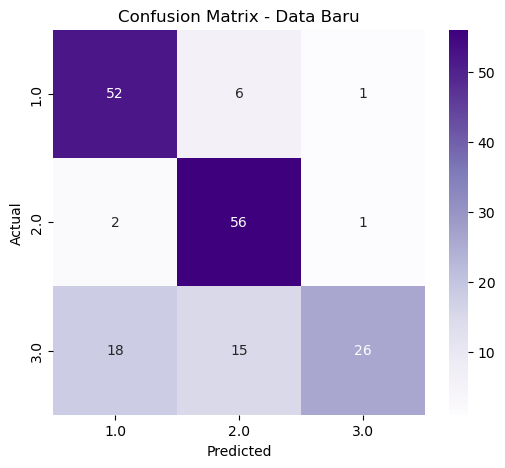

Sensitivity (Macro Recall) - Data Baru: 0.7571
Specificity (Macro) - Data Baru: 0.8785
Mean AUC - Data Baru: 0.9242


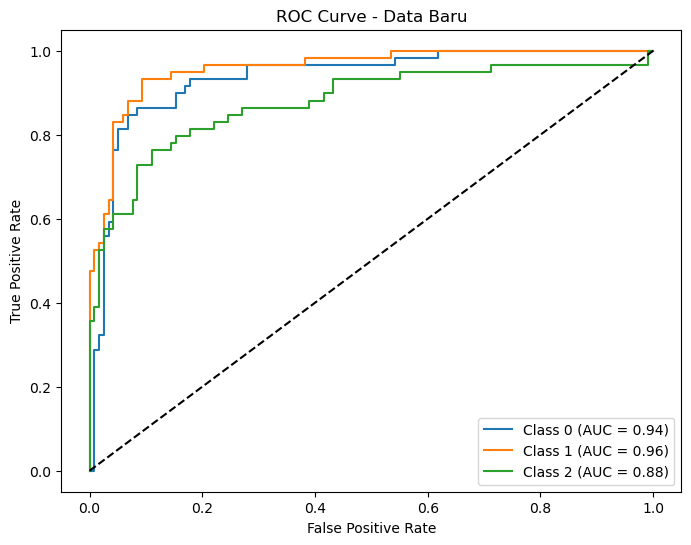

In [58]:
# === Step 1: Prediksi Data Baru ===
y_hasilpred = best_svm.predict(X_prediksi)

# Tambahkan kolom hasil prediksi ke dataframe jika ingin melihat hasilnya
df_fitur['kelas_prediksi'] = y_hasilpred

# === Step 2: Evaluasi Akurasi ===
akurasi_baru = accuracy_score(y_prediksi, y_hasilpred)
print(f"Akurasi pada data baru: {akurasi_baru:.4f}")


# === Step 7: F1 Score (Macro) dan Classification Report ===
f1_macro_baru = f1_score(y_prediksi, y_hasilpred, average='macro')
print(f"F1 Score (Macro) - Data Baru: {f1_macro_baru:.4f}")

print("\nClassification Report - Data Baru:")
print(classification_report(y_prediksi, y_hasilpred, digits=4))

# === Step 3: Confusion Matrix ===
cm_baru = confusion_matrix(y_prediksi, y_hasilpred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_baru, annot=True, fmt='d', cmap='Purples',
            xticklabels=np.unique(y_prediksi), yticklabels=np.unique(y_prediksi))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Data Baru')
plt.show()

# === Step 4: Sensitivitas (Recall Macro) ===
sensitivity_baru = recall_score(y_prediksi, y_hasilpred, average='macro')
print(f"Sensitivity (Macro Recall) - Data Baru: {sensitivity_baru:.4f}")

# === Step 5: Spesifisitas (Macro) ===
specificities_baru = []
for i in range(len(cm_baru)):
    tn = cm_baru.sum() - (cm_baru[i, :].sum() + cm_baru[:, i].sum() - cm_baru[i, i])
    fp = cm_baru[:, i].sum() - cm_baru[i, i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities_baru.append(specificity)
mean_specificity_baru = np.mean(specificities_baru)
print(f"Specificity (Macro) - Data Baru: {mean_specificity_baru:.4f}")

# === Step 6: ROC Curve & AUC (Multiclass) ===
y_pred_bin = label_binarize(y_prediksi, classes=np.unique(y_prediksi))
y_score_baru = best_svm.predict_proba(X_prediksi)  # Probabilitas prediksi
n_classes_baru = y_pred_bin.shape[1]

plt.figure(figsize=(8,6))
auc_values_baru = []
for i in range(n_classes_baru):
    fpr, tpr, _ = roc_curve(y_pred_bin[:, i], y_score_baru[:, i])
    roc_auc = auc(fpr, tpr)
    auc_values_baru.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

mean_auc_baru = np.mean(auc_values_baru)
print(f"Mean AUC - Data Baru: {mean_auc_baru:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Data Baru')
plt.legend()
plt.show()


In [59]:
Hasil_Prediksi = pd.DataFrame({'Epoch': list(range(1, 60)) * 3, 'Kelas_Asli': y_prediksi, 'Kelas_Prediksi': y_hasilpred})
Hasil_Prediksi

,Epoch,Kelas_Asli,Kelas_Prediksi
0,1,1.0,1.0
1,2,1.0,2.0
2,3,1.0,1.0
3,4,1.0,1.0
4,5,1.0,1.0
...,...,...,...
172,55,3.0,3.0
173,56,3.0,2.0
174,57,3.0,3.0
175,58,3.0,3.0


In [60]:
Hasil_Prediksi1, Hasil_Prediksi2, Hasil_Prediksi3 = [hasil.reset_index(drop=True) for hasil in np.array_split(Hasil_Prediksi, 3)]
print("Hasil_Prediksi1:\n", Hasil_Prediksi1)
print("Hasil_Prediksi2:\n", Hasil_Prediksi2)
print("Hasil_Prediksi3:\n", Hasil_Prediksi3)

Hasil_Prediksi1:
     Epoch  Kelas_Asli  Kelas_Prediksi
0       1         1.0             1.0
1       2         1.0             2.0
2       3         1.0             1.0
3       4         1.0             1.0
4       5         1.0             1.0
5       6         1.0             1.0
6       7         1.0             2.0
7       8         1.0             2.0
8       9         1.0             1.0
9      10         1.0             2.0
10     11         1.0             1.0
11     12         1.0             1.0
12     13         1.0             1.0
13     14         1.0             1.0
14     15         1.0             1.0
15     16         1.0             2.0
16     17         1.0             1.0
17     18         1.0             1.0
18     19         1.0             1.0
19     20         1.0             1.0
20     21         1.0             1.0
21     22         1.0             1.0
22     23         1.0             1.0
23     24         1.0             1.0
24     25         1.0           

d:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [61]:
label_kelas = {
    1: 'Normal',
    2: 'Depresi Rendah',
    3: 'Depresi Sedang'
}

# Fungsi plotting dengan label deskriptif
def plot_kelas(df, title):
    kelas_terbanyak = df['Kelas_Prediksi'].mode().iloc[0]
    label_terbanyak = label_kelas.get(int(kelas_terbanyak), 'Tidak diketahui')

    plt.figure(figsize=(8, 4))

    # Tambahkan teks di atas plot
    plt.text(0.5, 1.15, f'Kelas yang diprediksi yaitu: {label_terbanyak}',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

    # Plot garis Kelas Asli dan Prediksi
    plt.plot(df['Epoch'], df['Kelas_Asli'], label='Kelas Sebenarnya', marker='o', linestyle='-')
    plt.plot(df['Epoch'], df['Kelas_Prediksi'], label='Kelas Prediksi', marker='x', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Kelas')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(ticks=range(0, 59, 10))
    plt.yticks(ticks=[1, 2, 3], labels=['1', '2', '3'])
    plt.ylim(0.5, 3.5)  # karena kelas hanya 1, 2, 3  # karena kelas hanya 1, 2, 3
    plt.tight_layout()
    plt.show()

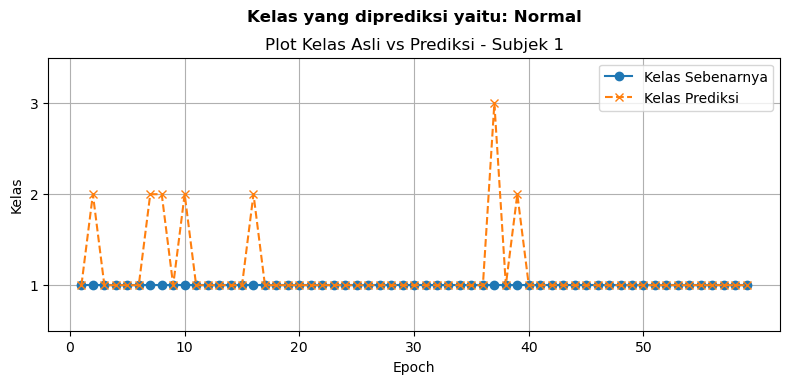

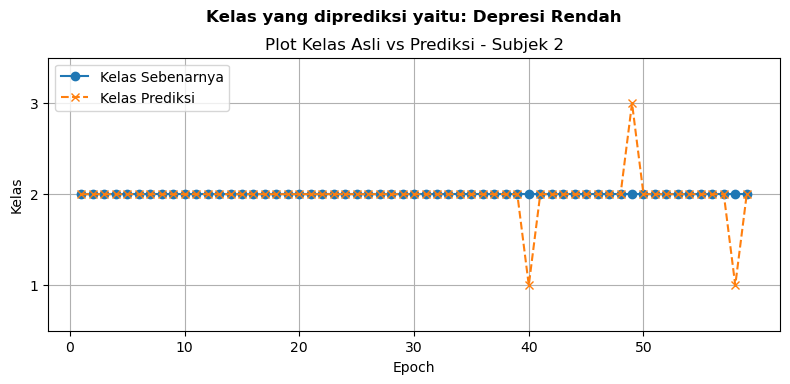

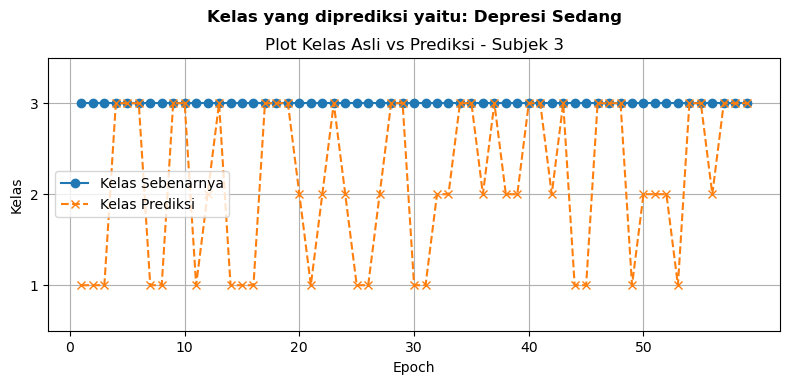

In [62]:
plot_kelas(Hasil_Prediksi1, 'Plot Kelas Asli vs Prediksi - Subjek 1')
plot_kelas(Hasil_Prediksi2, 'Plot Kelas Asli vs Prediksi - Subjek 2')
plot_kelas(Hasil_Prediksi3, 'Plot Kelas Asli vs Prediksi - Subjek 3')

## Bagging svm

Akurasi pada data baru: 0.7627
F1 Score (Macro) - Data Baru: 0.7384

Classification Report - Data Baru:
              precision    recall  f1-score   support

         1.0     0.7222    0.8814    0.7939        59
         2.0     0.7273    0.9492    0.8235        59
         3.0     0.9286    0.4407    0.5977        59

    accuracy                         0.7571       177
   macro avg     0.7927    0.7571    0.7384       177
weighted avg     0.7927    0.7571    0.7384       177



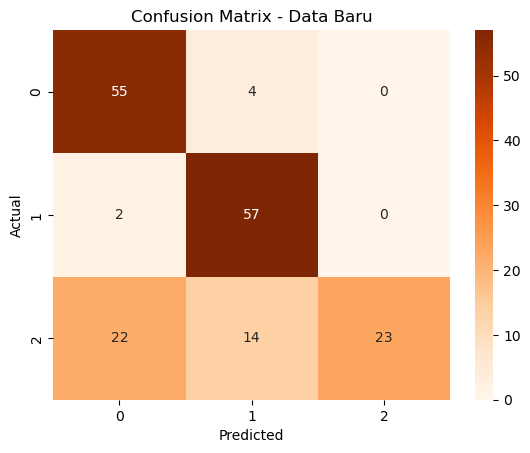

Sensitivity (Macro Recall) - Data Baru: 0.7627
Specificity (Macro) - Data Baru: 0.8814
Mean AUC - Data Baru: 0.9501


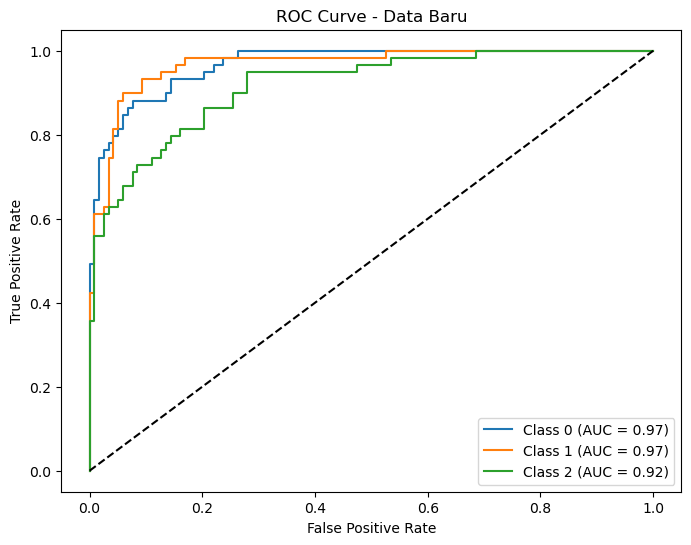

In [63]:
# === Step 9: Prediksi Data Baru ===
y_pred_baru = bagging_classifier.predict(X_prediksi)

# Tambahkan hasil prediksi ke dataframe jika ingin melihat hasilnya
df_fitur['kelas_prediksi'] = y_pred_baru

# === Step 10: Evaluasi Kinerja pada Data Baru ===
# Akurasi
akurasi_baru = accuracy_score(y_prediksi, y_pred_baru)
print(f"Akurasi pada data baru: {akurasi_baru:.4f}")

# === Step 7: F1 Score (Macro) dan Classification Report ===
f1_macro_baru = f1_score(y_prediksi, y_hasilpred, average='macro')
print(f"F1 Score (Macro) - Data Baru: {f1_macro_baru:.4f}")

print("\nClassification Report - Data Baru:")
print(classification_report(y_prediksi, y_hasilpred, digits=4))

# Confusion Matrix
cm_baru = confusion_matrix(y_prediksi, y_pred_baru)
sns.heatmap(cm_baru, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Data Baru')
plt.show()

# Sensitivitas (Recall Macro)
sensitivity_baru = recall_score(y_prediksi, y_pred_baru, average='macro')
print(f"Sensitivity (Macro Recall) - Data Baru: {sensitivity_baru:.4f}")

# Spesifisitas untuk multiclass
specificities_baru = []
for i in range(len(cm_baru)):
    tn = cm_baru.sum() - (cm_baru[i, :].sum() + cm_baru[:, i].sum() - cm_baru[i, i])
    fp = cm_baru[:, i].sum() - cm_baru[i, i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities_baru.append(specificity)
mean_specificity_baru = np.mean(specificities_baru)
print(f"Specificity (Macro) - Data Baru: {mean_specificity_baru:.4f}")

# ROC Curve dan Mean AUC (jika ingin plot)
y_pred_bin = label_binarize(y_prediksi, classes=np.unique(y_prediksi))
y_score_baru = bagging_classifier.predict_proba(X_prediksi)
n_classes_baru = y_pred_bin.shape[1]

plt.figure(figsize=(8, 6))
auc_values_baru = []
for i in range(n_classes_baru):
    fpr, tpr, _ = roc_curve(y_pred_bin[:, i], y_score_baru[:, i])
    roc_auc = auc(fpr, tpr)
    auc_values_baru.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Mean AUC
mean_auc_baru = np.mean(auc_values_baru)
print(f"Mean AUC - Data Baru: {mean_auc_baru:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Data Baru')
plt.legend()
plt.show()


In [64]:
Hasil_Prediksi = pd.DataFrame({'Epoch': list(range(1, 60)) * 3, 'Kelas_Asli': y_prediksi, 'Kelas_Prediksi': y_pred_baru})
Hasil_Prediksi

,Epoch,Kelas_Asli,Kelas_Prediksi
0,1,1.0,1.0
1,2,1.0,2.0
2,3,1.0,1.0
3,4,1.0,1.0
4,5,1.0,1.0
...,...,...,...
172,55,3.0,3.0
173,56,3.0,2.0
174,57,3.0,3.0
175,58,3.0,3.0


In [65]:
Hasil_Prediksi1, Hasil_Prediksi2, Hasil_Prediksi3 = [hasil.reset_index(drop=True) for hasil in np.array_split(Hasil_Prediksi, 3)]
print("Hasil_Prediksi1:\n", Hasil_Prediksi1)
print("Hasil_Prediksi2:\n", Hasil_Prediksi2)
print("Hasil_Prediksi3:\n", Hasil_Prediksi3)

Hasil_Prediksi1:
     Epoch  Kelas_Asli  Kelas_Prediksi
0       1         1.0             1.0
1       2         1.0             2.0
2       3         1.0             1.0
3       4         1.0             1.0
4       5         1.0             1.0
5       6         1.0             1.0
6       7         1.0             2.0
7       8         1.0             2.0
8       9         1.0             1.0
9      10         1.0             2.0
10     11         1.0             1.0
11     12         1.0             1.0
12     13         1.0             1.0
13     14         1.0             1.0
14     15         1.0             1.0
15     16         1.0             1.0
16     17         1.0             1.0
17     18         1.0             1.0
18     19         1.0             1.0
19     20         1.0             1.0
20     21         1.0             1.0
21     22         1.0             1.0
22     23         1.0             1.0
23     24         1.0             1.0
24     25         1.0           

d:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [66]:
label_kelas = {
    1: 'Normal',
    2: 'Depresi Rendah',
    3: 'Depresi Sedang'
}

# Fungsi plotting dengan label deskriptif
def plot_kelas(df, title):
    kelas_terbanyak = df['Kelas_Prediksi'].mode().iloc[0]
    label_terbanyak = label_kelas.get(int(kelas_terbanyak), 'Tidak diketahui')

    plt.figure(figsize=(8, 4))

    # Tambahkan teks di atas plot
    plt.text(0.5, 1.15, f'Kelas yang diprediksi yaitu: {label_terbanyak}',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

    # Plot garis Kelas Asli dan Prediksi
    plt.plot(df['Epoch'], df['Kelas_Asli'], label='Kelas Sebenarnya', marker='o', linestyle='-')
    plt.plot(df['Epoch'], df['Kelas_Prediksi'], label='Kelas Prediksi', marker='x', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Kelas')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(ticks=range(0, 59, 10))
    plt.yticks(ticks=[1, 2, 3], labels=['1', '2', '3'])
    plt.ylim(0.5, 3.5)  # karena kelas hanya 1, 2, 3
    plt.tight_layout()
    plt.show()

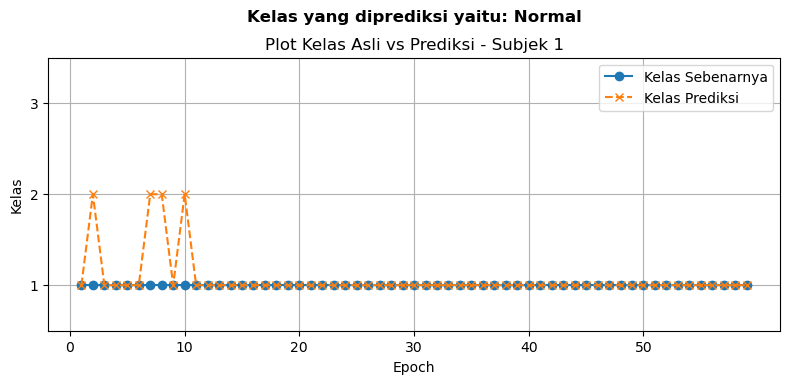

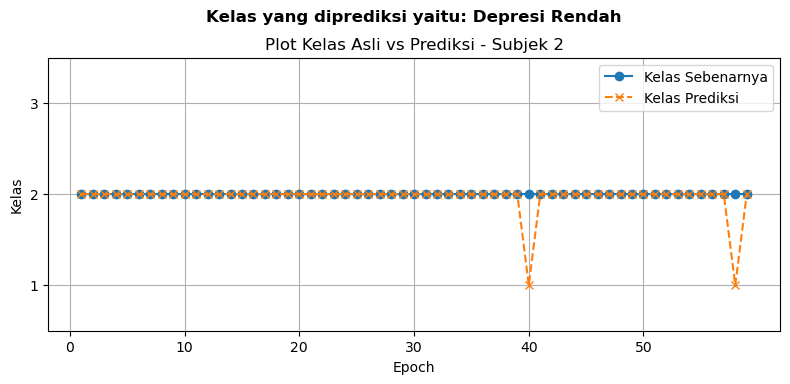

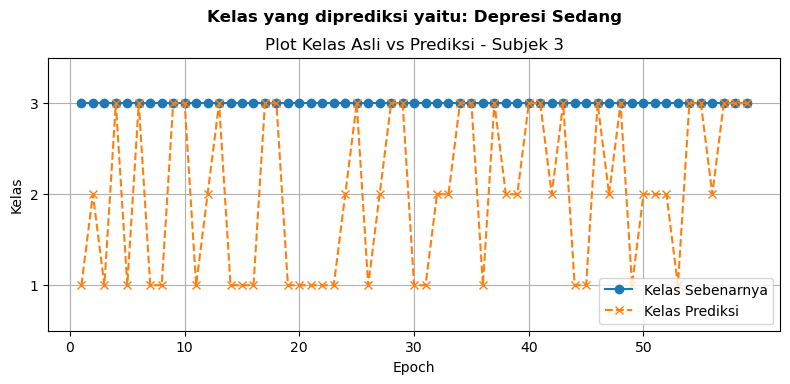

In [67]:
plot_kelas(Hasil_Prediksi1, 'Plot Kelas Asli vs Prediksi - Subjek 1')
plot_kelas(Hasil_Prediksi2, 'Plot Kelas Asli vs Prediksi - Subjek 2')
plot_kelas(Hasil_Prediksi3, 'Plot Kelas Asli vs Prediksi - Subjek 3')

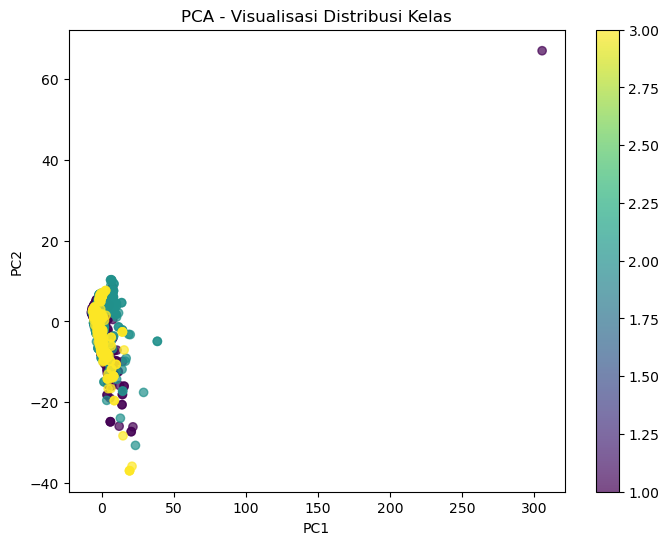

In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('PCA - Visualisasi Distribusi Kelas')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

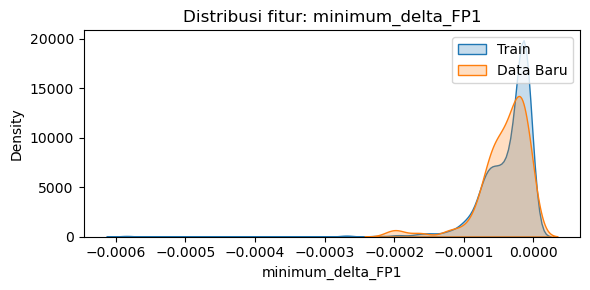

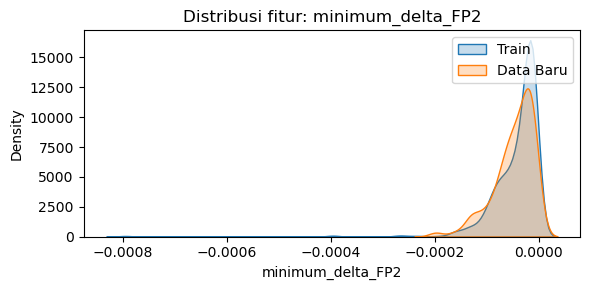

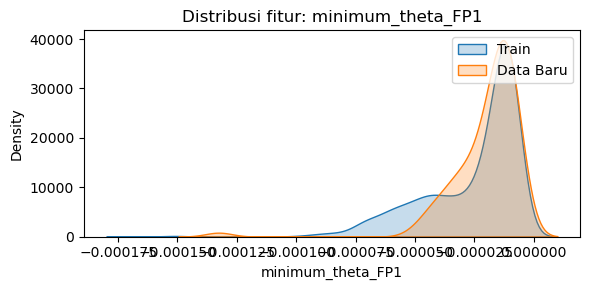

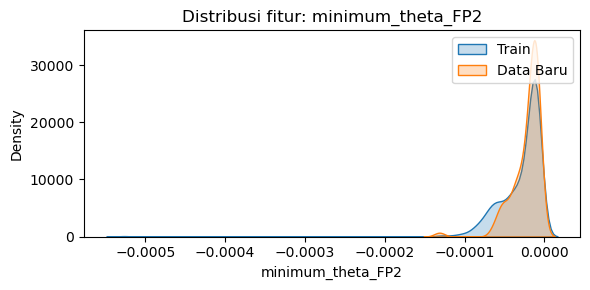

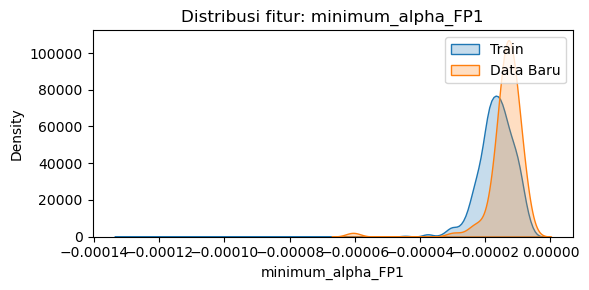

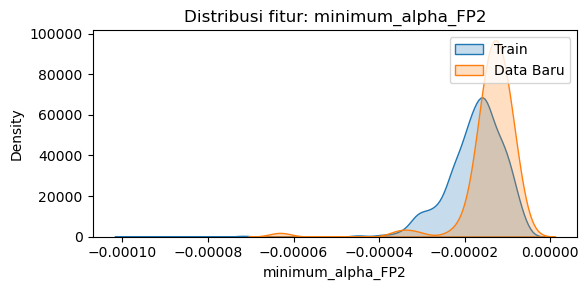

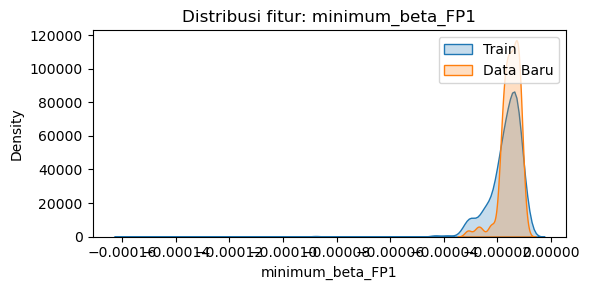

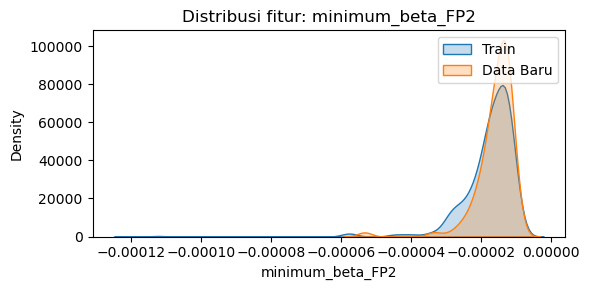

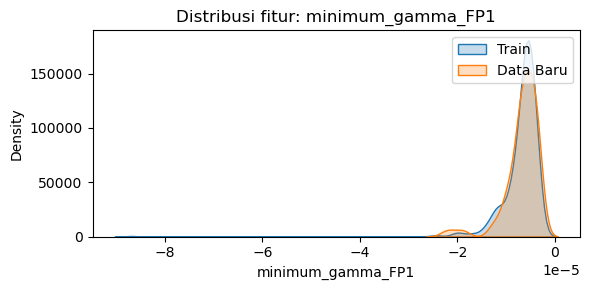

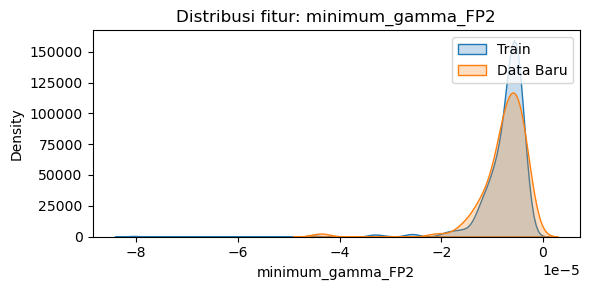

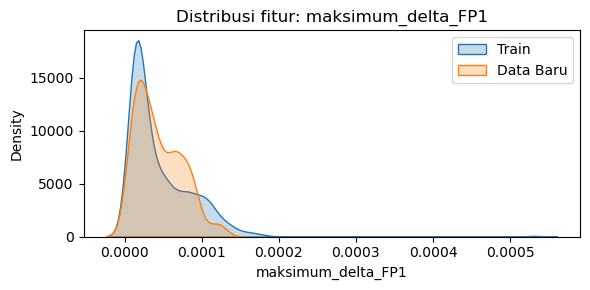

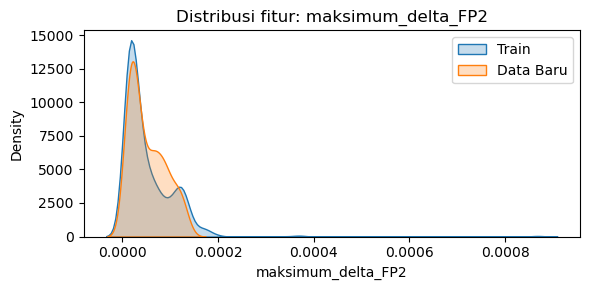

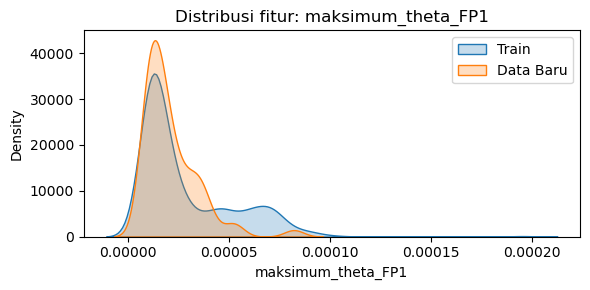

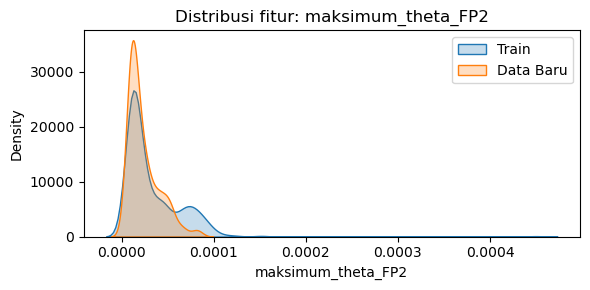

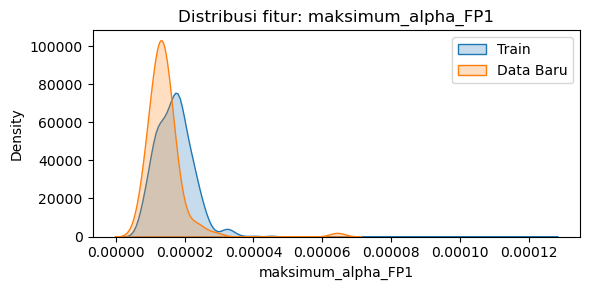

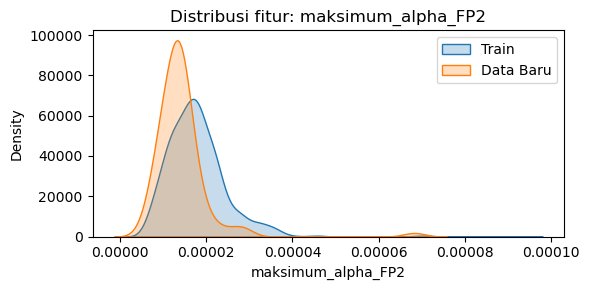

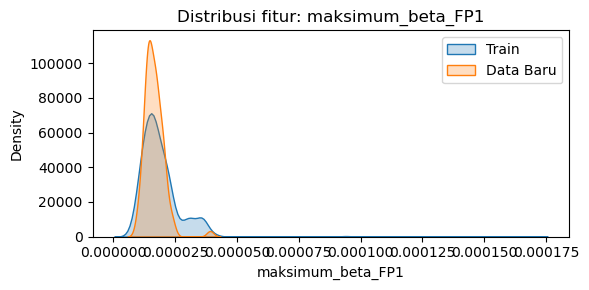

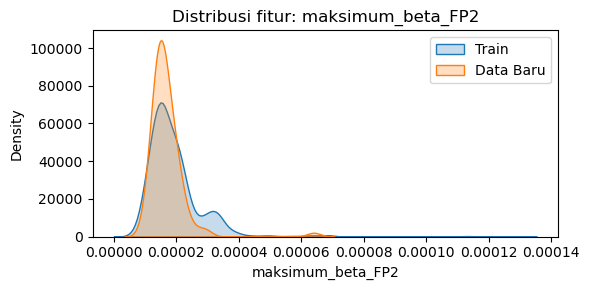

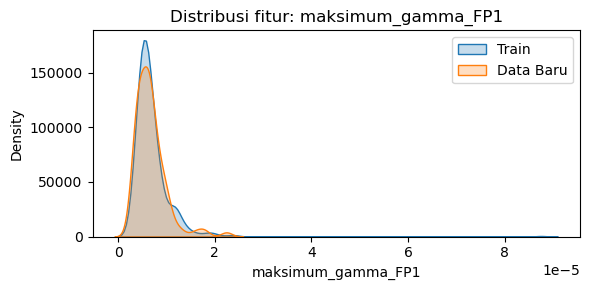

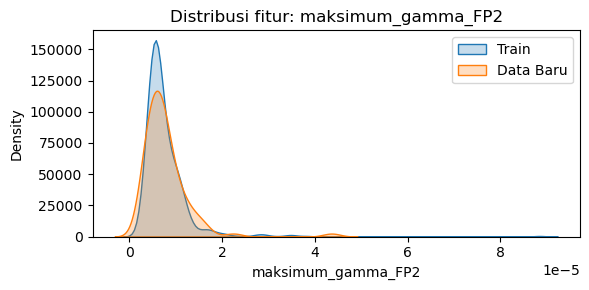

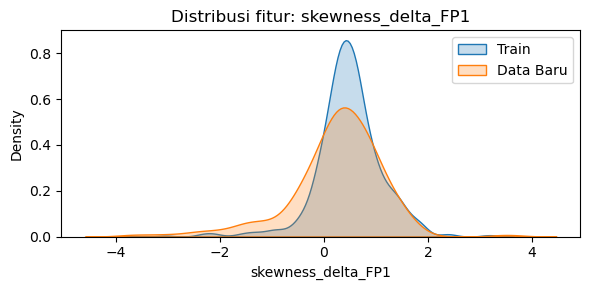

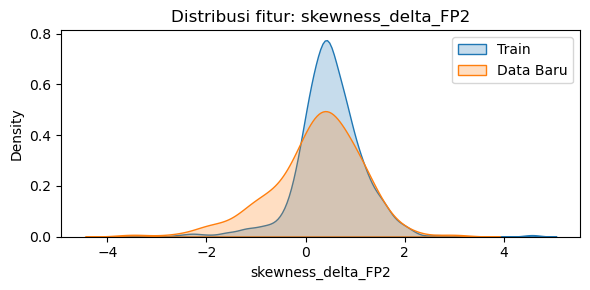

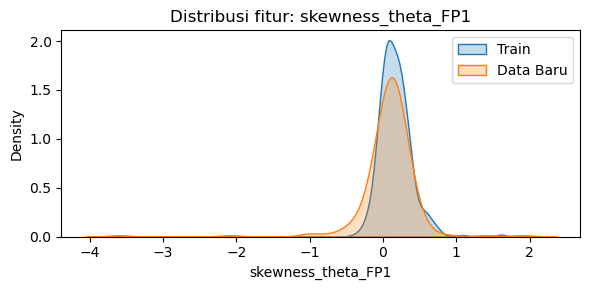

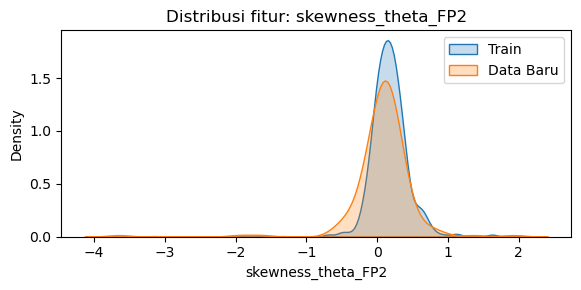

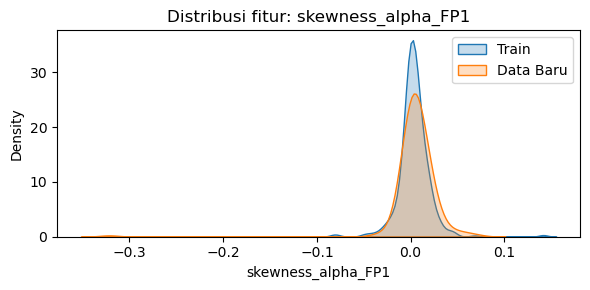

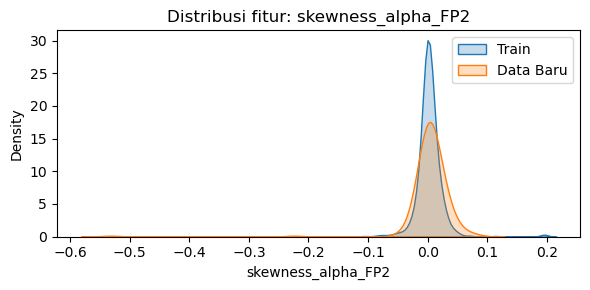

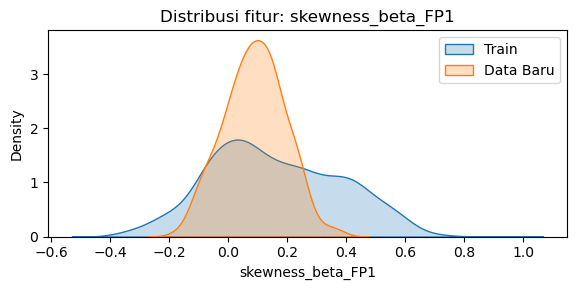

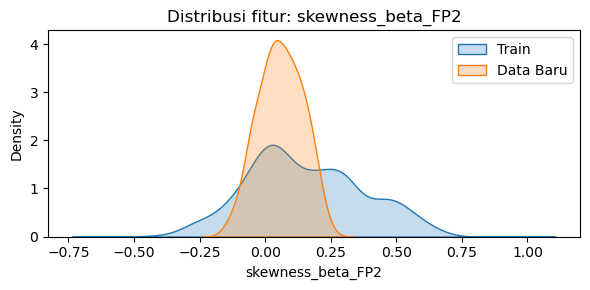

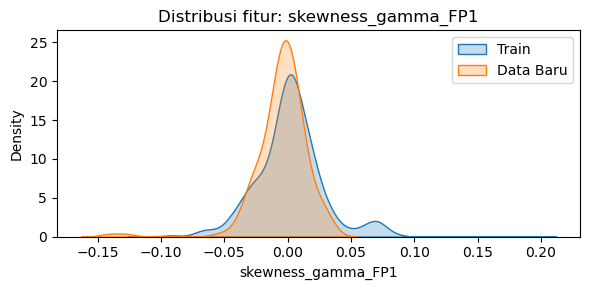

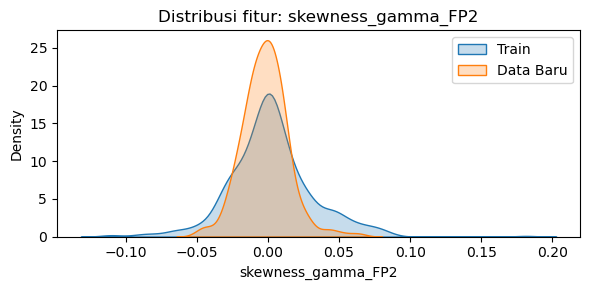

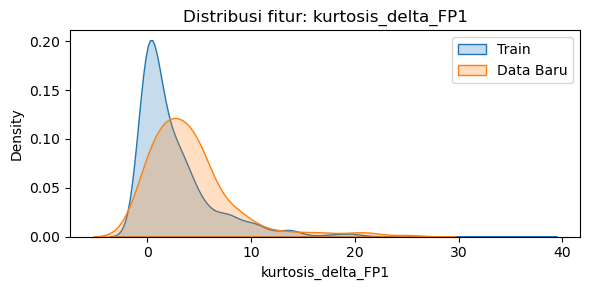

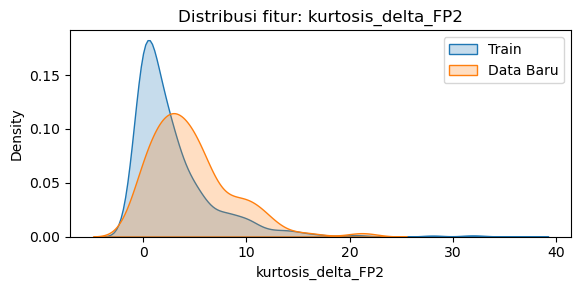

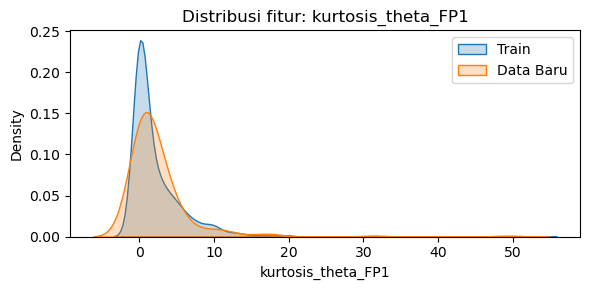

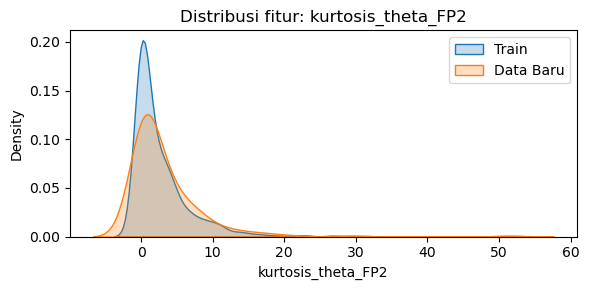

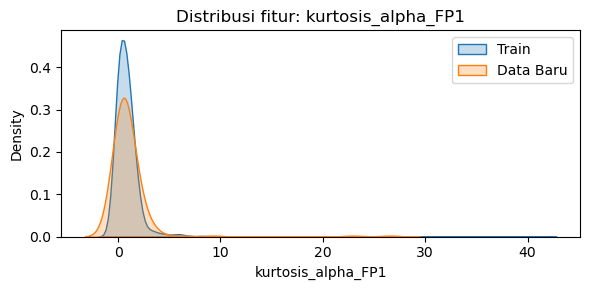

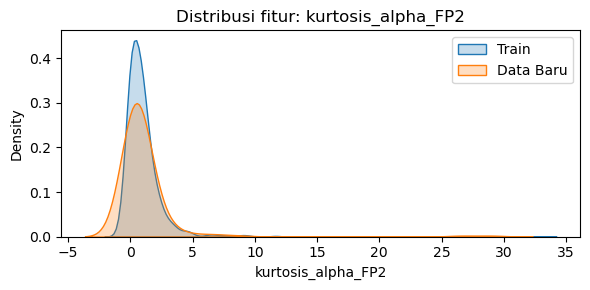

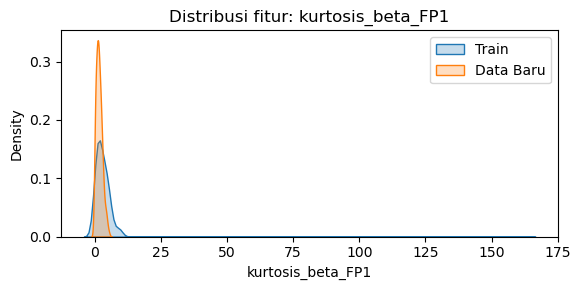

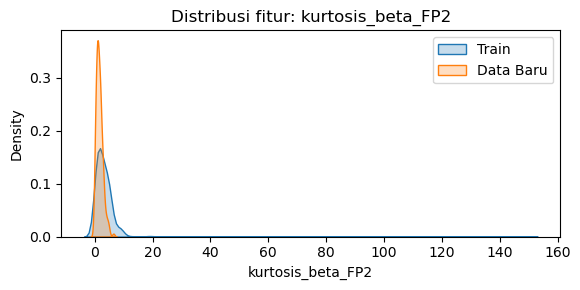

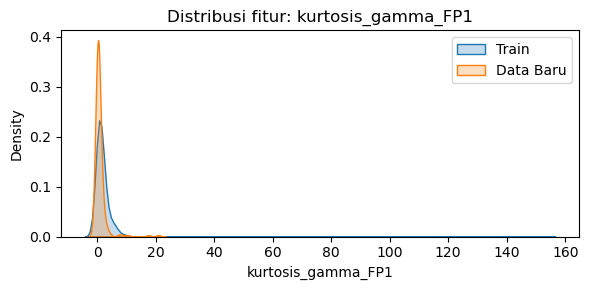

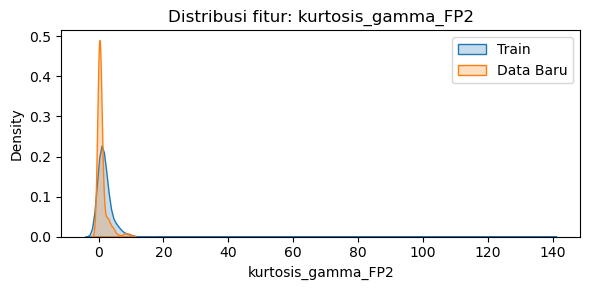

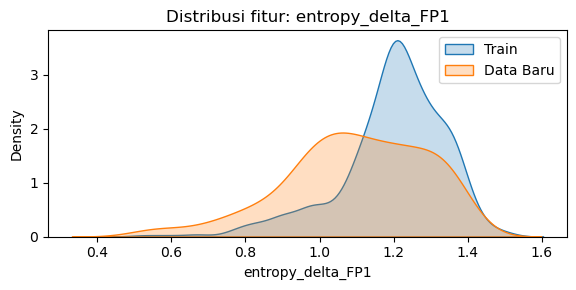

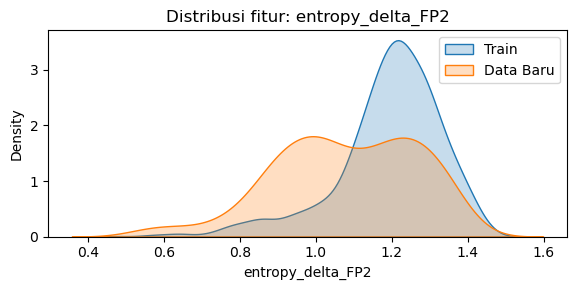

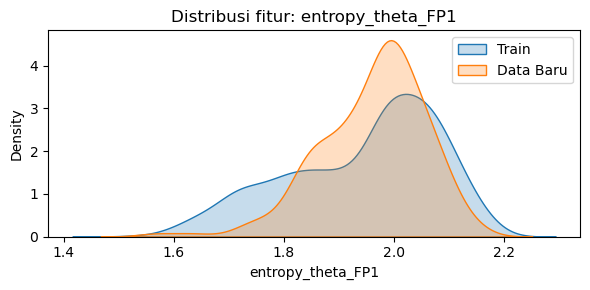

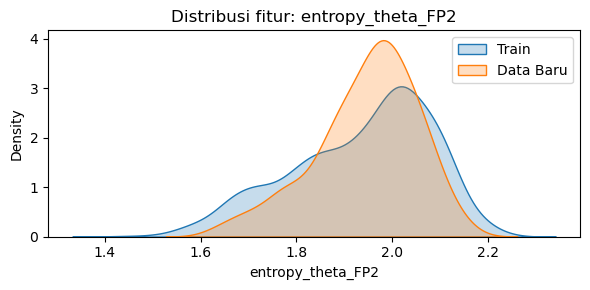

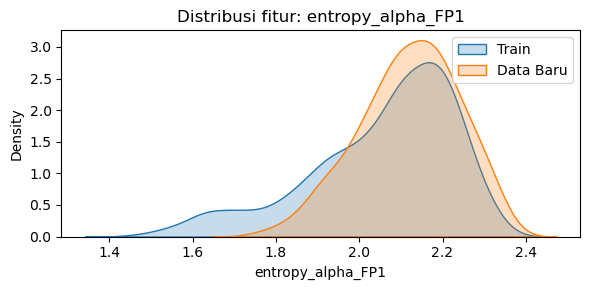

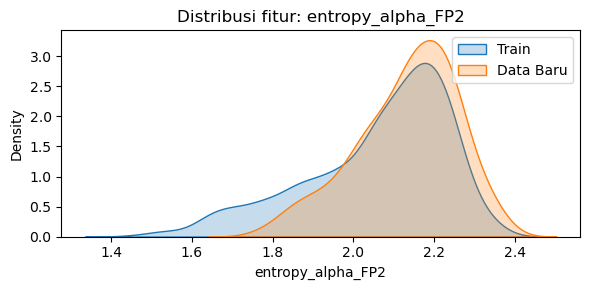

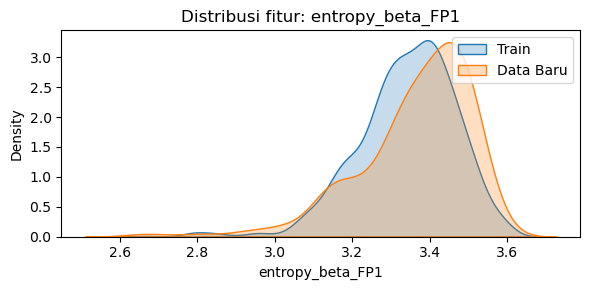

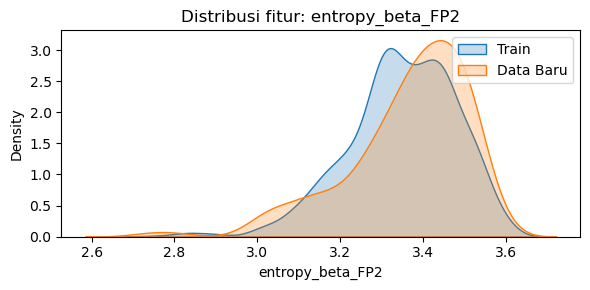

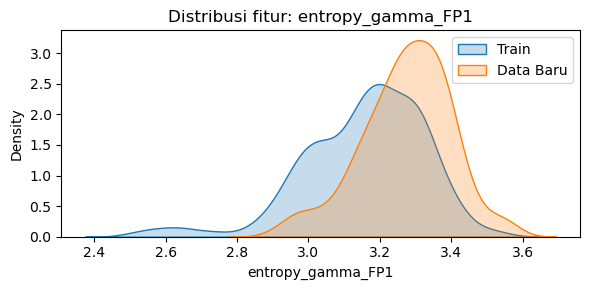

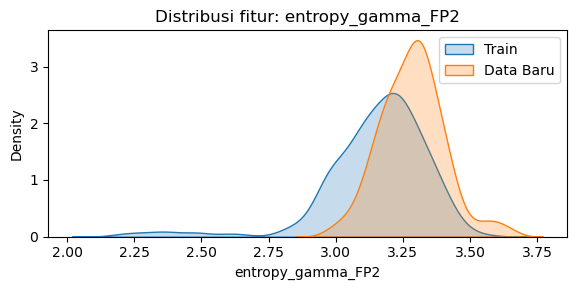

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in X_train.columns:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(X_train[col], label='Train', fill=True)
    sns.kdeplot(X_prediksi[col], label='Data Baru', fill=True)
    plt.title(f'Distribusi fitur: {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [70]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, wasserstein_distance, entropy

hasil_density = []

for col in X_train.columns:
    # Ambil nilai
    data_train = X_train[col].dropna().values
    data_pred = X_prediksi[col].dropna().values
    
    # KDE estimasi
    kde_train = gaussian_kde(data_train)
    kde_pred = gaussian_kde(data_pred)
    
    # Buat grid nilai (rentang umum dari kedua dataset)
    xmin = min(data_train.min(), data_pred.min())
    xmax = max(data_train.max(), data_pred.max())
    x_grid = np.linspace(xmin, xmax, 1000)
    
    # Hitung density
    density_train = kde_train(x_grid)
    density_pred = kde_pred(x_grid)
    
    # Normalisasi (untuk KL divergence)
    density_train /= density_train.sum()
    density_pred /= density_pred.sum()
    
    # Hitung jarak
    l1_distance = np.sum(np.abs(density_train - density_pred))
    kl_div = entropy(density_train + 1e-10, density_pred + 1e-10)  # tambahkan epsilon untuk menghindari log(0)
    wass_dist = wasserstein_distance(data_train, data_pred)
    
    hasil_density.append({
        'Fitur': col,
        'L1_Distance': l1_distance,
        'KL_Divergence': kl_div,
        'Wasserstein_Distance': wass_dist
    })

# Hasil sebagai DataFrame
df_perbedaan_density = pd.DataFrame(hasil_density)


In [71]:
df_perbedaan_density.sort_values(by='L1_Distance', ascending=False).head(20)

,Fitur,L1_Distance,KL_Divergence,Wasserstein_Distance
27,skewness_beta_FP2,0.871373,3.811738,0.125232
37,kurtosis_beta_FP2,0.736235,1.234072,1.556868
26,skewness_beta_FP1,0.713667,1.782769,0.105575
39,kurtosis_gamma_FP2,0.687132,0.441632,1.149825
41,entropy_delta_FP2,0.665897,0.264498,0.113814
36,kurtosis_beta_FP1,0.661054,1.594688,1.368875
5,minimum_alpha_FP2,0.654651,0.457851,0.000004
4,minimum_alpha_FP1,0.634459,0.349981,0.000003
15,maksimum_alpha_FP2,0.630319,0.405551,0.000004
14,maksimum_alpha_FP1,0.610912,0.336778,0.000003
